# MODULES, IMPORTS, LIBRARIES AND CONSTANT

#### modules, libraries and imports

In [2]:
# FILE READING
from os import listdir
from torchaudio.transforms import Spectrogram, AmplitudeToDB
from torchaudio import load
from torch import Tensor

# Fundamentals
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# METRICS
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from seaborn import heatmap


#### CONSTANTS

In [3]:
# Reading constants
DATA_PATH = './data/dev/'
METRICS_W_PARAM={accuracy_score:None, balanced_accuracy_score:None,
                    recall_score:{'average':'macro'}, precision_score:{'average':'macro'}, f1_score:{'average':'macro'}}


# Classifiers Chosen
CLASSIFIERS = [ RandomForestClassifier(**{'criterion': 'entropy', 'n_estimators': 200}),
                KNeighborsClassifier(**{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}),
                SVC(**{'degree': 3, 'kernel': 'linear', 'probability': True})
                ]
CLASSIFIERS_ACCURACY = [ 0.9643542782442616, 0.9601806787239386, 0.97221804903412] 
BEST_ROWS = 26
BEST_COLS = 4

# Classification and output on file
EVAL_INPUT_DATA_PATH = './data/eval/'
OUTPUT_FILE = './prediction/myPrediction.csv'


# DATA AUGMENTATION
AUGMENT_DATA = False
AUGMENTED_DATA_PATH = "./data/dataAugmentation/recordings/"
OUTPUT_AUGMENTED_FILE = './prediction/myPredictionAUG.csv'


# FILE READ

Reads the file in the given path and returns:
- reads the file and evaluates the spectrogram in db for each wav file
- reads the class associated to the file and returns a series using as index the file name and as values the classes

In [4]:
def loadDataAsSpectrogram(path:str)->dict[str:Tensor]:
    return {file:AmplitudeToDB()(Spectrogram()(load(path+file)[0]))[0] for file in listdir(path) if file.endswith('.wav')}

def loadDataClasses(path:str)->pd.Series:
    return pd.Series({file:file.split("_")[-1].split('.')[0] for file in listdir(path) if file.endswith('.wav')}).astype(int)

Reads the augmented data:
- Returns the spectrogram of the augmented data
- Returns the classes of the augmented data

In [5]:
def loadAugmentedDataAsSpectrogram(path:str)->dict[str:Tensor]:
    return {file:AmplitudeToDB()(Spectrogram()(load(path+file)[0]))[0] for file in listdir(path) if file.endswith('.wav')}

def loadAugmentedDataClasses(path:str)->pd.Series:
    return pd.Series({file:file.split("_")[0] for file in listdir(path) if file.endswith('.wav')}).astype(int)

# COMPUTE SUB MATRIX

Divides the spectrogram matrix into sub matrix (such that there are rows*cols sub matrix) and each one of this sub matrix is then summed up by means of the mean value and the standard deviation. <br> All the sub matrices are disjoint
<br> Also the sub matrix are then reshaped to be a one dimensional vector using a row major philosophy

In [6]:
def createSubMatrix(data:Tensor, rows:int, cols:int)->dict[str:np]:
    return ({key:np.array([data[key][data[key].shape[0]//rows * i: min(data[key].shape[0]//rows * (i+1), data[key].shape[0]), data[key].shape[1]//cols * j: min(data[key].shape[1]//cols * (j+1), data[key].shape[1])].mean() for i in range(rows) for j in range(cols)]) for key in data},
            {key:np.array([data[key][data[key].shape[0]//rows * i: min(data[key].shape[0]//rows * (i+1), data[key].shape[0]), data[key].shape[1]//cols * j: min(data[key].shape[1]//cols * (j+1), data[key].shape[1])].std() for i in range(rows) for j in range(cols)]) for key in data})

# CREATE DATAFRAME

A dataframe is created having as rows the file name (index) and as columns the mean and the standard deviation of the sub matrices, which are one dimensionally stretched out, the first columns are relative to the mean, the others to the standard deviation.
<br>
The function can work with either a tuple containing both mean and std or with the two parameter passed separately

In [7]:
def createDf(mean_std:dict[str:np], std:dict[str:np]=False)->pd.DataFrame:
    return pd.concat([pd.DataFrame(mean_std if std else mean_std[0]), pd.DataFrame(std if std else mean_std[1])], axis=0).T

# TRAIN THE CLASSIFIERS

The vector of classifier is trained and then is used to predict the data values <br>
The prediction is then returned as a dataframe having as indexes the name of the files and as columns the classifier used <br>
in each cell there is the prediction for said file and said classifier

In [8]:
def BuildClassifiers(classifiers:list[RandomForestClassifier], xTrain:pd.DataFrame, yTrain:pd.Series, xPred:pd.Series)->pd.DataFrame:
    return pd.DataFrame([clf.fit(xTrain, yTrain).predict(xPred) for clf in classifiers], columns=xPred.index, index=[str(clf).split('(')[0] for clf in classifiers]).T

# REDUCE THE CLASSIFICATION

Reduces the classification by implementing a weighted majority voting algorithm, where the weight were previously defined by the sole model f1_score during the validation phase

In [9]:
def reduceToOneClass(df:pd.DataFrame, clfAcc:list)->pd.DataFrame:
    diz = {}
    for index in df.index:
        temp = np.zeros(10)
        
        for i in range(len(clfAcc)):
            temp[int(df.loc[index, :].iloc[i])] += clfAcc[i]
        
        diz[index] = temp.argmax()
    
    return pd.Series(diz, index=df.index)

# PLOT SIGNAL

plots a given signal by the index of it in the time domain

In [10]:
def plotSignal(df:pd.DataFrame, index:str)->None:
    fig, ax = plt.subplot(figsize=(10,10))
    ax.set_title(index)
    ax.plot(df.columns.difference(['class', 'energy', 'power']).sort_values(), 
        df.loc[index, df.columns.difference(['class', 'energy', 'power'])])
    
    ax.grid(visible=True)
    plt.show()
    plt.tight_layout()
    
    
def plotMultipleSignal(df: pd.DataFrame, index:list[str])->None:
    fig, ax = plt.subplots(len(index)//2 + (1 if len(index) % 2 else 0), 2,figsize=(20,40))
    for j in range(2):
        for i in range(len(index)//2 + (1 if len(index) % 2 else 0)): 
            if j*2+i < len(index):
                ax[i,j].set_title(index[j*2+i])
                ax[i,j].plot(df.columns.difference(['class', 'energy', 'power']).sort_values(), 
                    df.loc[index[j*2+i], df.columns.difference(['class', 'energy', 'power'])])
                
                ax[i,j].grid(visible=True)
                
    plt.show()
    plt.tight_layout()

# SIGNAL POWER AND ENERGY

The signal power and energy are here calculated per each signal

In [11]:
def addEnergyAndPower(df:pd.DataFrame, plot:bool=False)->pd.DataFrame:
    df['energy'] = df.loc[:, df.columns.difference(['class'])].apply(func=lambda x: x**2).sum(axis=1)**0.5
    df = pd.concat([df, pd.Series(data=[df.loc[index, 'energy']/(df.loc[index,:].dropna().shape[0]-2) for index in df.index], index=df.index, name='power'), ], axis=1)
    
    if plot:
        fig, ax = plt.subplots(2,1, figsize=(20,10))
        ax[0].scatter(df['class'], df['energy']) 
        ax[0].set_title('Class vs Energy') 
        ax[0].set_xlabel('Class')
        ax[0].set_ylabel('Energy')
        
        ax[1].scatter(df['class'], df['power']) 
        ax[1].set_title('Class vs Power') 
        ax[1].set_xlabel('Class')
        ax[1].set_ylabel('Power')
    
    return df

# TEST METRICS

Tests all useful metrics on a given model

In [12]:
def testAllMetrics(yTrue:pd.DataFrame|pd.Series, yPred:pd.DataFrame|pd.Series, metrics: dict, printConfusionMatrix:bool=False)->pd.DataFrame:
    if printConfusionMatrix:
        heatmap(confusion_matrix(yTrue, yPred), annot=True)
    return pd.DataFrame({str(metric).split()[1]:metric(yTrue, yPred, **metrics[metric]) if metrics[metric] else metric(yTrue, yPred) for metric in metrics}, 
                        index=['values'])

# MAIN FUNCTION

This is the main function that coordinates all the execution of the program, that is used for building and testing the model

,accuracy_score,balanced_accuracy_score,recall_score,precision_score,f1_score
values,0.96,0.961468,0.961468,0.961435,0.960398


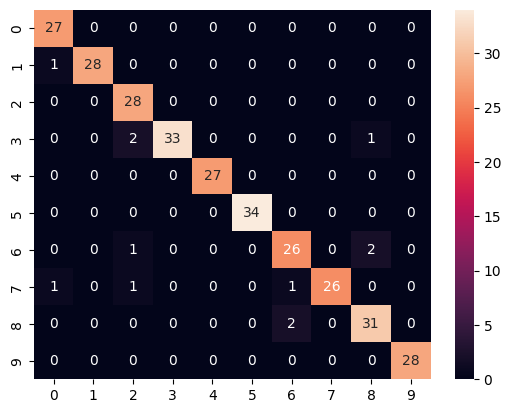

In [13]:
def main()->None:        
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(createDf(createSubMatrix(loadDataAsSpectrogram(DATA_PATH), BEST_ROWS, BEST_COLS)).sort_index(), 
                                                    loadDataClasses(DATA_PATH).sort_index(), test_size=0.20)

    display(testAllMetrics(Ytest, reduceToOneClass(BuildClassifiers(CLASSIFIERS, Xtrain, Ytrain, Xtest), CLASSIFIERS_ACCURACY),
                            metrics=METRICS_W_PARAM, printConfusionMatrix=True))

main()

# PREDICTION FUNCTION

This function is used to classify the eval data (even supporting data augmentation)

In [ ]:
def classify():
    if AUGMENT_DATA:
        # Loads data
        data = loadAugmentedDataAsSpectrogram(AUGMENTED_DATA_PATH)
        data.update(loadDataAsSpectrogram(DATA_PATH))
        
        # Note all this code is done in one row for compactness
        # Loads classes
        # classes= pd.concat([loadAugmentedDataClasses(AUGMENTED_DATA_PATH), loadDataClasses(DATA_PATH)], axis=0).sort_index()
        
        # Updates the data
        # df = createDf(createSubMatrix(data), BEST_ROWS, BEST_COLS).sort_index()
        
        yPred = reduceToOneClass(BuildClassifiers(CLASSIFIERS, 
                                                    createDf(createSubMatrix(data, BEST_ROWS, BEST_COLS)).sort_index(), 
                                                    pd.concat([loadAugmentedDataClasses(AUGMENTED_DATA_PATH), loadDataClasses(DATA_PATH)], axis=0).sort_index(), 
                                createDf(
                                    createSubMatrix(loadDataAsSpectrogram(EVAL_INPUT_DATA_PATH), BEST_ROWS, BEST_COLS)
                                    ).sort_index()), CLASSIFIERS_ACCURACY)
    else:
        df = createDf(createSubMatrix(loadDataAsSpectrogram(DATA_PATH), BEST_ROWS, BEST_COLS)).sort_index()
        classes = loadDataClasses(DATA_PATH).sort_index()
        yPred = reduceToOneClass(BuildClassifiers(CLASSIFIERS, df, classes, 
                            createDf(createSubMatrix(
                                loadDataAsSpectrogram(EVAL_INPUT_DATA_PATH), BEST_ROWS, BEST_COLS) 
                                    ).sort_index()), CLASSIFIERS_ACCURACY)
    
    yPred.set_axis(labels=list(map(lambda x: int(str(x).split('.')[0]),  yPred.index)), axis='index').sort_index().to_csv(path_or_buf=OUTPUT_AUGMENTED_FILE if AUGMENT_DATA else OUTPUT_FILE)
    

classify()

# TESTING MODELS AND HYPER PARAMETERS

### Testing the best configuration for the number of matrix per each element rows and columns by f1_score metric

In [ ]:
def testingConfigMatrix()->set[int, int, float]: 
    classes = loadDataClasses(DATA_PATH)
    df = loadDataAsSpectrogram(DATA_PATH)
    maximum = set()
    for i in range(20, 80, 3):
        for j in range(3, 7):
            try:
                data = createDf(createSubMatrix(df, i, j))
            except Exception:
                print(i, j, ' key error')
                continue

            
            if set(data.count()) != {1500}:
                print(i, j, ' has np.nan')
                continue

            Xtrain, Xtest, Ytrain, Ytest = train_test_split(data.sort_index(), classes.sort_index(), test_size=0.20)


            temp = reduceToOneClass(BuildClassifiers(CLASSIFIERS, Xtrain, Ytrain, Xtest), CLASSIFIERS_ACCURACY)

            maximum.add((i, j, f1_score(Ytest, temp,average='macro')))
    
    return maximum

for line in sorted(testingConfigMatrix(), key=lambda x: x[2], reversed=True):
    print(line)

### Test the optimal configuration of different models by f1_score metric 

#### Random Forest classifier 
BEST: 0.9643542782442616 {'criterion': 'entropy', 'n_estimators': 200}

In [ ]:
min0 = 0

for param in ParameterGrid(param_grid={
    'n_estimators':list(range(100, 800, 100)),
    'criterion':['gini', 'log_loss', 'entropy']
}):
    f1 = f1_score(Ytest, RandomForestClassifier(**param).fit(Xtrain, Ytrain).predict(Xtest), average='macro')
    if f1 > min0:
        min0 = f1
        parameter = param

print(min0, parameter)

#### SVC CLASSIFIER 
BEST:0.97221804903412 {'degree': 3, 'kernel': 'linear', 'probability': True}

In [ ]:
min2=0
for param in ParameterGrid(param_grid={
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':list(range(3, 10)),
    'probability':[True, False],
}):
    f1 = f1_score(Ytest, SVC(**param).fit(Xtrain, Ytrain).predict(Xtest), average='macro')
    if f1 > min2:
        min2 = f1
        parameter2 = param

print(min2, parameter2)

#### k nearest neighbors classifier
Best  0.9601806787239386 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [ ]:
min2=0
for param in ParameterGrid(param_grid={
    'n_neighbors':[5, 10, 20, 30],
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p':[1,2,3]
}):
    f1 = f1_score(Ytest, KNeighborsClassifier(**param).fit(Xtrain, Ytrain).predict(Xtest), average='macro')
    if f1 > min2:
        min2 = f1
        parameter2 = param

print(min2, parameter2)

#### Decision tree classifier

0.70690466016627 {'criterion': 'log_loss', 'max_depth': 10, 'splitter': 'random'}<br>
0.6976586924578915 {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}<br>
NOTE: tested but not used due to low f1_score

In [ ]:
from sklearn.tree import DecisionTreeClassifier
min3 = 0

for param in ParameterGrid(param_grid={
    'criterion':['gini', 'entropy', 'log_loss'] ,
    'splitter':['best', 'random'],
    'max_depth':[None, 4, 8, 10,]
}):
    f1 = f1_score(Ytest, DecisionTreeClassifier(**param).fit(Xtrain, Ytrain).predict(Xtest), average='macro')
    if f1 > min3:
        min3 = f1
        parameter3 = param

print(min3, parameter3)